In [36]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os


from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


In [37]:
# Define o nome do arquivo de log
log_filename = 'project_output.txt'

# Abre o arquivo em modo de escrita ('w') ou append ('a')
# 'w' vai sobrescrever o arquivo a cada execução
# 'a' vai adicionar ao final do arquivo a cada execução
log_file = open(log_filename, 'w')

# Redireciona a saída padrão (stdout) para o arquivo de log
sys.stdout = log_file

In [38]:
# Read the two CSV files and concatenate them
df_historic = pd.read_csv('historic.csv')


In [39]:
# print(df_historic.info())

In [40]:
# Filter clients who have ever defaulted (default_status == 1)
print(f"How many clients have defaulted: {len(df_historic[df_historic['default_status'] == 1]['id_client'].unique())} ")
print(f"Total of clients: {len(df_historic['id_client'].unique())} ")


In [56]:
# clear dataset to remove null data
df_credit_clear = df_historic.dropna()
# transform id_client to int
df_credit_clear['id_client'] = df_credit_clear['id_client'].str.replace('CLIENT_', '').replace('.', '').replace(',', '').replace('-', '').replace('/', '').astype(int)

In [42]:
# Convert date columns to datetime objects
date_cols = ['loan_date', 'loan_due_date', 'payment_date']
for col in date_cols:
    df_credit_clear[col] = pd.to_datetime(df_credit_clear[col])

# Calculate loan duration and days to payment
df_credit_clear['loan_duration_days'] = (df_credit_clear['loan_due_date'] - df_credit_clear['loan_date']).dt.days
# df_credit_clear['days_to_payment'] = (df_credit_clear['payment_date'] - df_credit_clear['loan_due_date']).dt.days


########## Data Preparation for Modeling ##########

In [43]:
# Ensure default_status is integer type
df_credit_clear['default_status'] = df_credit_clear['default_status'].astype(int)

# Select features for the Random Forest model
# Exclude original categorical columns, date columns, and id_client
features = [ 
    'total_hectares_client', 'loan_amount', 'income',
    'loan_amount_term', 'rating', 'score', 'total_debt',
    'short_term_debt', 'medium_term_debt', 'long_term_debt',
    'loan_duration_days', 'culture', 'hectare_rented'
]
# 'days_to_payment',
#Split dataset into features and target variable
dt_x = df_credit_clear[features]
dt_y = df_credit_clear['default_status']

# Define target names for classification reports and plots
target_names = ['Not Default', 'Default'] # Assuming 0 is 'Not Default' and 1 is 'Default'


In [44]:
# Train-Test Split (Transaction-wise)
# Since we are now analyzing individual transactions, the split will be done per transaction.
# Stratify to maintain class distribution in train and test sets
X_train, X_test, y_train, y_test = train_test_split(dt_x, dt_y, test_size=0.2, random_state=42, stratify=dt_y)

print(f"\nX_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


In [45]:
# Standardize numerical features using StandardScaler
# It's crucial to fit the scaler ONLY on the training data to prevent data leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames for easier handling (optional but good practice)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


########## Model Training and Evaluation ##########

In [46]:
model = RandomForestClassifier()

cv_results = cross_val_score(model, X_train, y_train, cv=10, scoring='precision')
cv_results

array([0.59296482, 0.59235669, 0.59633028, 0.60224877, 0.59594595,
       0.59746657, 0.58551724, 0.59695291, 0.60625   , 0.59985886])

Additional Machine Learning Models

In [47]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name, target_names, plot_feature_importance=False):
    """
    Trains a given model, makes predictions, and evaluates its performance.

    Args:
        model: The scikit-learn model to be trained.
        X_train (pd.DataFrame): Training features (scaled).
        y_train (pd.Series): Training target variable.
        X_test (pd.DataFrame): Test features (scaled).
        y_test (pd.Series): Test target variable.
        model_name (str): Name of the model for display purposes.
        target_names (list): List of class names for the classification report.
        plot_feature_importance (bool): If True, plots feature importance (for tree-based models).

    Returns:
        dict: A dictionary containing evaluation metrics.
    """
    print(f"\n--- Training and Evaluating {model_name} ---")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    print("\nConfusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=target_names,
                yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Plot Feature Importance if requested and model supports it
    if plot_feature_importance and hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X_train.columns
        forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=forest_importances, y=forest_importances.index)
        plt.title(f"Feature Importances ({model_name})")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc_score': roc_auc
    }

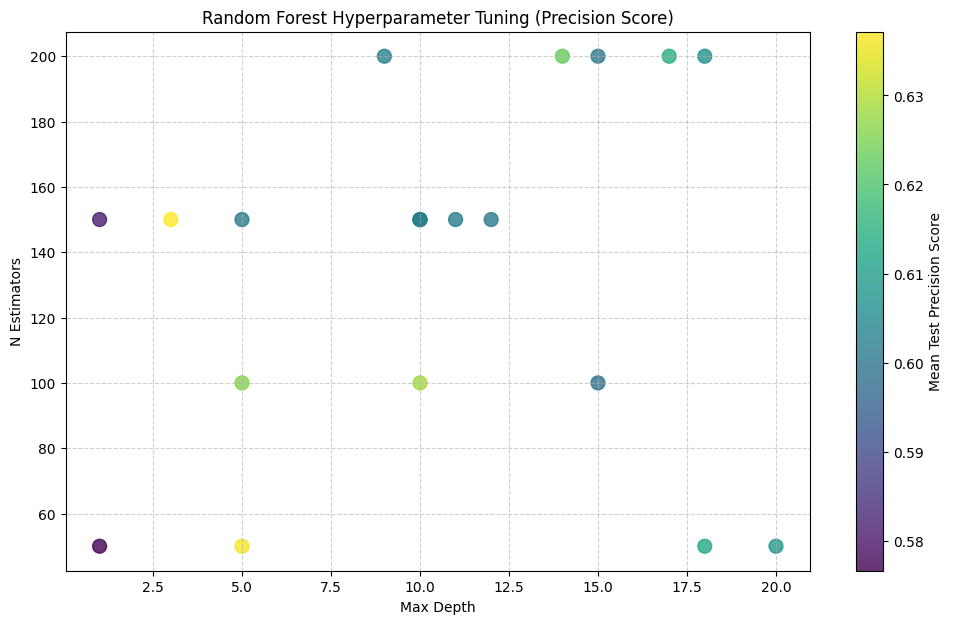

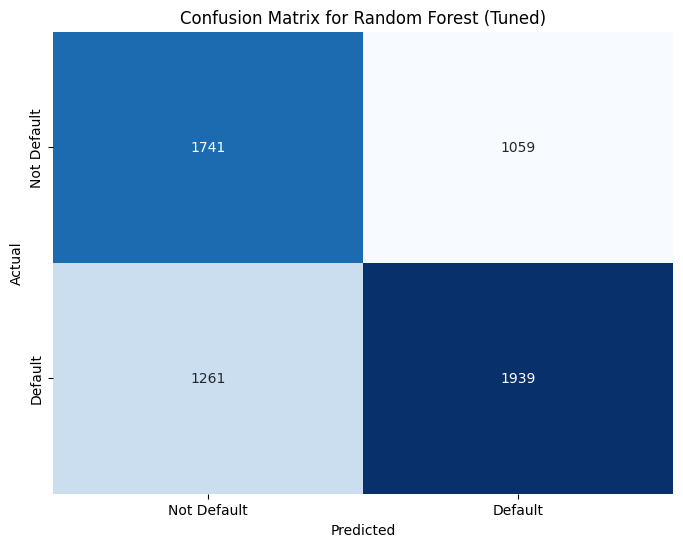

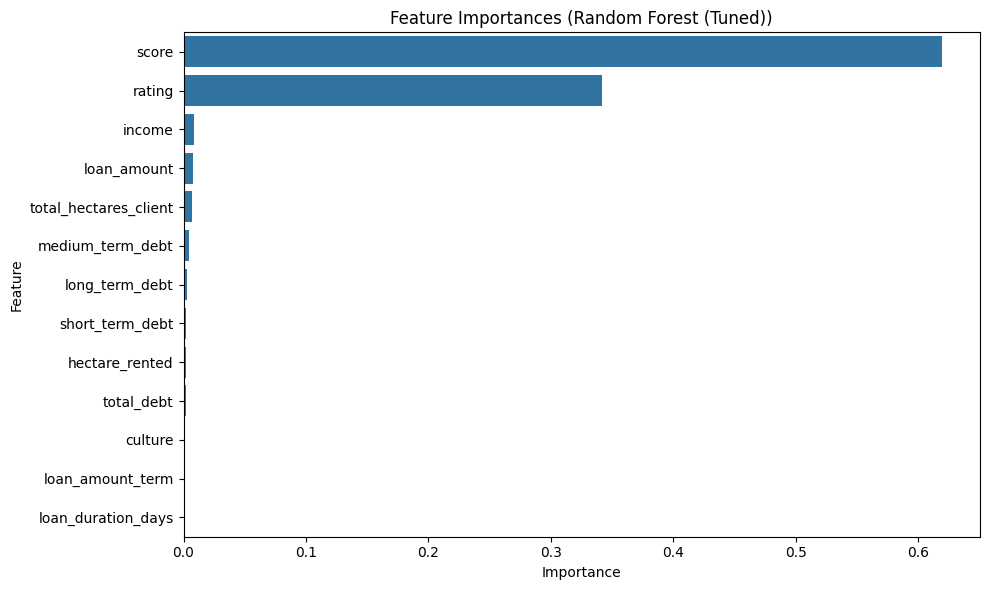

In [48]:
# --- 1. Random Forest Classifier - Hyperparameter Tuning ---
print("--- Random Forest Hyperparameter Tuning with RandomizedSearchCV ---")

# Define parameter grid for RandomizedSearchCV
# np.arange(1, 101) creates numbers from 1 to 100
# np.linspace(0.001, 0.5, 100) creates 100 evenly spaced numbers between 0.001 and 0.5
parameter_grid = {
    'n_estimators': [50, 100, 150, 200], # Number of trees in the forest
    'max_depth': np.arange(1, 21), # Max depth of the tree
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4], # Minimum number of samples required to be at a leaf node
    'max_features': [ 'sqrt', 'log2', 0.5, 0.7, 0.9], # Number of features to consider when looking for the best split
    'class_weight': ['balanced', None] # Handle class imbalance
}

number_iterations = 20 # Number of parameter settings that are sampled

rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=parameter_grid,
    n_iter=number_iterations,
    scoring='precision', # Use precision as the scoring metric for tuning
    cv=5, # 5-fold cross-validation during search
    verbose=1, # Show progress
    random_state=42,
    n_jobs=-1 # Use all available CPU cores
)

rf_random_search.fit(X_train_scaled, y_train)

print(f"\nBest Parameters for Random Forest: {rf_random_search.best_params_}")
print(f"Best Precision Score (Cross-validated): {rf_random_search.best_score_:.4f}")

# Plot hyperparameter tuning results
tested_n_estimators = [r['n_estimators'] for r in rf_random_search.cv_results_['params']]
tested_max_depth = [r['max_depth'] for r in rf_random_search.cv_results_['params']]

plt.figure(figsize=(12, 7))
plt.scatter(tested_max_depth, tested_n_estimators, c=rf_random_search.cv_results_['mean_test_score'], cmap='viridis', s=100, alpha=0.8)
plt.colorbar(label='Mean Test Precision Score')
plt.gca().set(xlabel='Max Depth', ylabel='N Estimators', title='Random Forest Hyperparameter Tuning (Precision Score)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Use the best estimator found by RandomizedSearchCV for final evaluation
best_rf_model = rf_random_search.best_estimator_
rf_metrics = train_and_evaluate_model(best_rf_model, X_train_scaled, y_train, X_test_scaled, y_test,
                                      "Random Forest (Tuned)", target_names, plot_feature_importance=True)


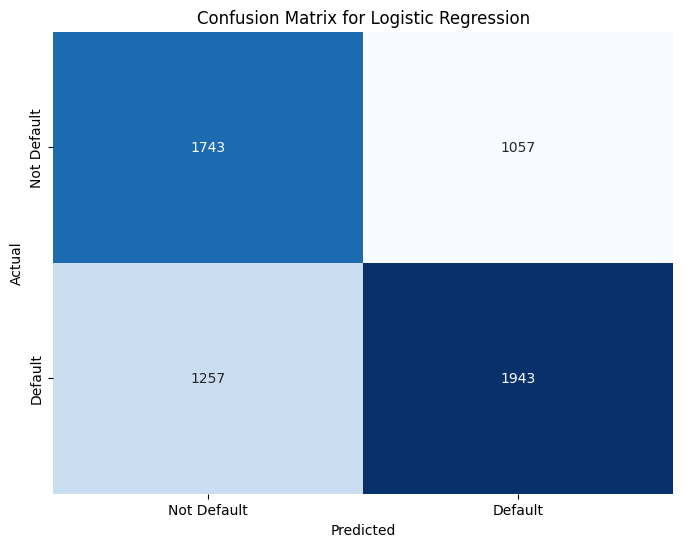

In [49]:
# --- 2. Logistic Regression ---
# Using solver='liblinear' for smaller datasets and 'balanced' class_weight
lr_model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000)
lr_metrics = train_and_evaluate_model(lr_model, X_train_scaled, y_train, X_test_scaled, y_test, "Logistic Regression", target_names)


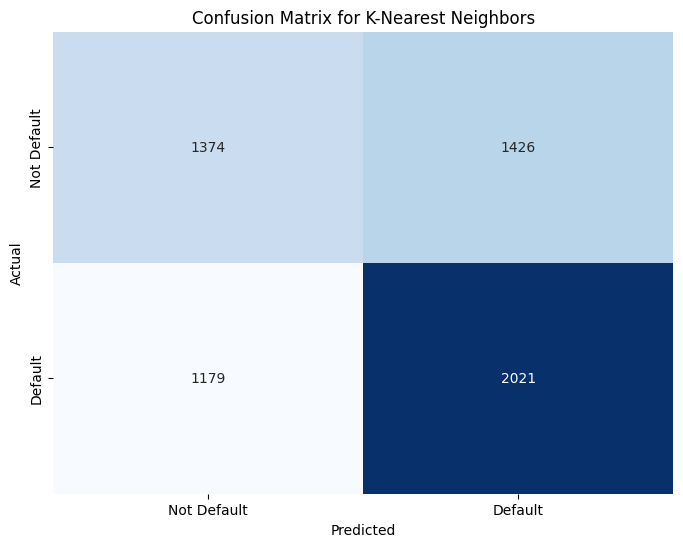

In [50]:
# --- 3. K-Nearest Neighbors ---
# n_neighbors is a key hyperparameter, consider tuning this for optimal performance
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_metrics = train_and_evaluate_model(knn_model, X_train_scaled, y_train, X_test_scaled, y_test, "K-Nearest Neighbors", target_names)


########## Comparative Analysis of Model Performance ##########

In [51]:
def compare_models_results(all_metrics):
    """
    Compares the performance metrics of different models and discusses implications.

    Args:
        all_metrics (list of dict): A list where each dict contains metrics for a model.
    """
    print("\n--- Comparative Analysis of Model Performance ---")

    metrics_df = pd.DataFrame(all_metrics)
    metrics_df = metrics_df.set_index('model_name')

    print("\nSummary of Key Metrics:")
    print(metrics_df.round(4))

    # Plotting comparison
    metrics_df[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score']].plot(
        kind='bar', figsize=(14, 8), rot=45, colormap='viridis'
    )
    plt.title('Comparison of Model Performance Metrics')
    plt.ylabel('Score')
    plt.legend(loc='lower right', bbox_to_anchor=(1.05, 1)) # Adjust legend position
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("\n--- Discussion and Implications ---")
    best_roc_auc_model = metrics_df['roc_auc_score'].idxmax()
    best_f1_model = metrics_df['f1_score'].idxmax()
    best_precision_model = metrics_df['precision'].idxmax()
    best_recall_model = metrics_df['recall'].idxmax()

    print(f"Based on **ROC AUC Score** (a good overall indicator for imbalanced datasets, measuring separability of classes), the **{best_roc_auc_model}** performed best.")
    print(f"For **F1-Score** (harmonic mean of precision and recall, balancing false positives and false negatives), the **{best_f1_model}** showed the strongest balance.")
    print(f"When prioritizing **Precision** (minimizing false positives, e.g., incorrectly flagging a client as defaulting unnecessarily), the **{best_precision_model}** was superior.")
    print(f"For **Recall** (minimizing false negatives, e.g., missing actual defaults, which can be costly), the **{best_recall_model}** performed best.")

    print("\n**Implications for Data Adequacy (All Transactions):**")
    print("By analyzing all transactions instead of just the latest, the models are now learning patterns associated with individual loan behaviors and their outcomes. This can provide a more granular understanding of default drivers across the entire history of interactions.")
    print("The varying strengths across different models indicate that while the provided features are informative, the choice of model can significantly influence prediction performance for different business objectives. For instance, if the cost of missing a default (low recall) is higher than the cost of a false alarm (low precision), a model with higher recall might be preferred.")
    print("The generally positive performance across the models suggests that the selected features (`total_hectares_client`, `loan_amount`, etc.) are indeed **adequate and contain predictive power** for identifying default risk in individual transactions. However, there's always room for improvement through more advanced feature engineering (e.g., creating interaction terms, polynomial features, or explicitly incorporating time-series aspects if the sequence of transactions is important) or by exploring more complex models.")
    print("This comparative analysis helps confirm that the current dataset provides a solid foundation for building effective default prediction models on a transaction-by-transaction basis.")


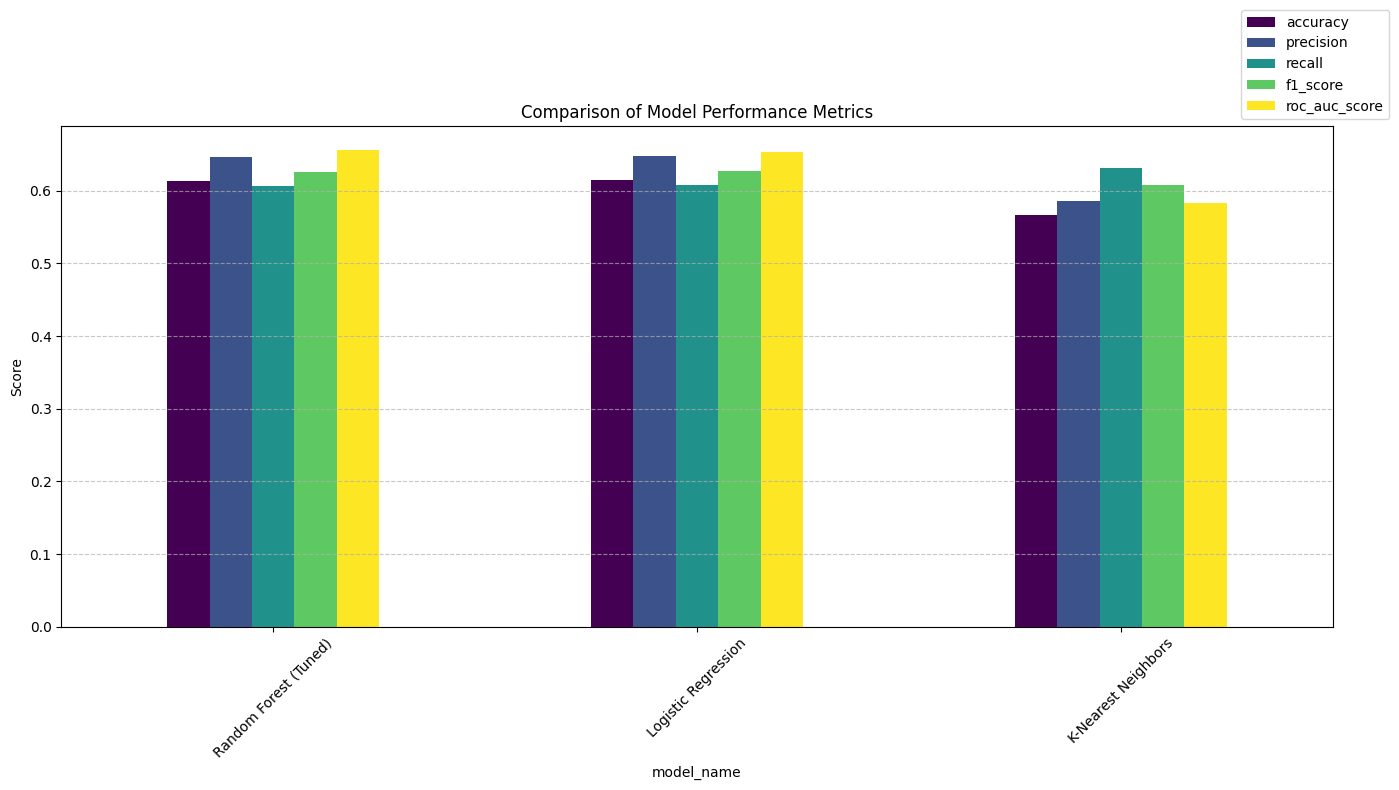

In [52]:
# Collect all model metrics for comparison
all_model_metrics = [rf_metrics, lr_metrics, knn_metrics] # Ensure order is consistent if preferred

# Run the comparative analysis
compare_models_results(all_model_metrics)

In [53]:
# Restaurar a saída padrão para o console/notebook
sys.stdout = sys.__stdout__
log_file.close() # Fechar o arquivo de log

print(f"\nTodos os outputs foram salvos em '{log_filename}'")